In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score

In [42]:
pip install pykalman


In [43]:
from pykalman import KalmanFilter

In [44]:
df = pd.read_csv('mean_power.csv', sep=',', header=0, index_col=0)
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075259 entries, 1 to 2075259
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   DateTime               object 
dtypes: float64(7), object(1)
memory usage: 142.5+ MB


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [45]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.dtypes

df.reset_index().set_index('DateTime')

,index,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,,
2006-12-16 17:24:00,1,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,2,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,3,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,4,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,5,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,2075255,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,2075256,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,2075257,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [46]:
df_day=df.resample('d', on='DateTime').mean()

df_day = df_day.drop('Voltage', axis=1 )

In [47]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_day)
df_scaled =pd.DataFrame(scaled)

In [48]:
df_day["target"] = df_day.Global_active_power.shift(-1)
df_day = df_day.iloc[:-1,:]

In [49]:
values = df_day.values
num_test = 365

test = values[:num_test, :]
train = values[num_test:, :]

X_train, y_train = train[:,1:], train[:,0]
X_test, y_test = test[:,1:], test[:,0]

In [50]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(1076, 1, 6) (1076,) (365, 1, 6) (365,)


In [51]:


model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],  X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=2)

Epoch 1/100
11/11 - 2s - loss: 0.7382 - 2s/epoch - 184ms/step
Epoch 2/100
11/11 - 0s - loss: 0.1135 - 51ms/epoch - 5ms/step
Epoch 3/100
11/11 - 0s - loss: 0.0673 - 45ms/epoch - 4ms/step
Epoch 4/100
11/11 - 0s - loss: 0.0523 - 48ms/epoch - 4ms/step
Epoch 5/100
11/11 - 0s - loss: 0.0376 - 47ms/epoch - 4ms/step
Epoch 6/100
11/11 - 0s - loss: 0.0346 - 54ms/epoch - 5ms/step
Epoch 7/100
11/11 - 0s - loss: 0.0310 - 62ms/epoch - 6ms/step
Epoch 8/100
11/11 - 0s - loss: 0.0295 - 62ms/epoch - 6ms/step
Epoch 9/100
11/11 - 0s - loss: 0.0269 - 55ms/epoch - 5ms/step
Epoch 10/100
11/11 - 0s - loss: 0.0239 - 60ms/epoch - 5ms/step
Epoch 11/100
11/11 - 0s - loss: 0.0232 - 52ms/epoch - 5ms/step
Epoch 12/100
11/11 - 0s - loss: 0.0221 - 54ms/epoch - 5ms/step
Epoch 13/100
11/11 - 0s - loss: 0.0208 - 62ms/epoch - 6ms/step
Epoch 14/100
11/11 - 0s - loss: 0.0196 - 57ms/epoch - 5ms/step
Epoch 15/100
11/11 - 0s - loss: 0.0174 - 68ms/epoch - 6ms/step
Epoch 16/100
11/11 - 0s - loss: 0.0168 - 56ms/epoch - 5ms/step
E

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               42800     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [53]:
y_pred = model.predict(X_test)

In [54]:
X_test = X_test.reshape((X_test.shape[0], 6))

In [55]:
# Invert scaling for prediction
inv_x = np.concatenate((y_pred, X_test[:, -5:]), axis=1)
inv_x = scaler.inverse_transform(inv_x)
inv_y_pred = inv_x[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]

In [56]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
print('RMSE value : {}'.format(rmse))

# calculate R2 Score
r2 = r2_score(inv_y, inv_y_pred)
print("R2 Score : {}".format(r2))

RMSE value : 0.13001080526267522
R2 Score : 0.9935234181643606


In [57]:
kf = KalmanFilter(initial_state_mean=inv_y[0])
kf = kf.em(inv_y, n_iter=1, em_vars='all')
measurements_predicted = (kf.smooth(inv_y_pred)[0])[:, 0]

In [58]:
import math
trainScore1 = math.sqrt(mean_squared_error(inv_y, inv_y_pred))
trainScore1_r2 = r2_score(inv_y, inv_y_pred)
print('Score Before Kalman Filtering: %.2f RMSE and %.2f R-Square' % (trainScore1, trainScore1_r2))

Score Before Kalman Filtering: 0.13 RMSE and 0.99 R-Square


In [59]:
trainScore2 = math.sqrt(mean_squared_error(inv_y, measurements_predicted))
trainScore2_r2 = r2_score(inv_y, measurements_predicted)
print('Score After Kalman Filtering: %.2f RMSE and %.2f R-Square' % (trainScore2, trainScore2_r2))


Score After Kalman Filtering: 0.69 RMSE and 0.82 R-Square


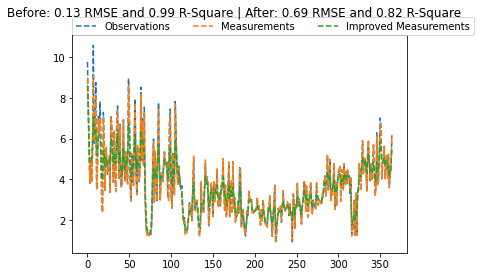

In [60]:
line1, = plt.plot(inv_y, label="Observations", linestyle='--')
line2, = plt.plot(inv_y_pred, label="Measurements", linestyle='--')
line3, = plt.plot(measurements_predicted, label="Improved Measurements", linestyle='--')

plt.legend(handles=[line1, line2, line3], bbox_to_anchor=(0., 1, 1.2, 1), loc=3, borderaxespad=0., mode='expand',
           ncol=3)

#plt.xlabel('Time step')
#plt.ylabel('Global Active Power')
plt.suptitle('Before: %.2f RMSE and %.2f R-Square | After: %.2f RMSE and %.2f R-Square' % (
trainScore1, trainScore1_r2, trainScore2, trainScore2_r2))

plt.show()